# Churchland Widefield Data

This notebook demonstrates:
- Running a ARHMM on PCA-transformed reconstructions
- Neural data is transformed with PCA over each brain region

In [1]:
# Import statements
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from ssm import LDS
from Session import *
from LVM import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import ssm
from ssm import HMM
from ssm.util import find_permutation

In [2]:
from matplotlib.cm import get_cmap
cmap = get_cmap('coolwarm')

## 1. Load data and region indices

In [3]:
def undo_zscore(neural, predictions):
    """
    Assumes data is trial x time x components
    
    Args:
        neural: original neural activity
        predictions: predicted z-scored activity
    Returns:
        predictions with the z-scoring undone
    """

    predictions = predictions.copy()
    predictions *= np.std(neural, axis=(0,1))
    predictions += np.mean(neural, axis=(0,1))
    return predictions

def zscore(data):
    """
    Assumes data is trial x time x components
    """

    data -= np.mean(data, axis=(0,1))
    data /= np.std(data, axis=(0,1))
    return data

In [4]:
# Load the data into SESSION, NEUR_DATA, NEUR_DATA_EXCERPT

# Sesion, and full neural data
session = Session("vistrained", "mSM30", "10-Oct-2017")
neur_data = session.neural['neural']
delay_period_indices = session.get_delay_period(include_stim=True)

# Predictions
bn_version = 'version_223'
ffdatadir = "/home/chingf/Code/Widefield/analysis/musall/vistrained/mSM30/10-Oct-2017/ae-neural/16_latents/ff/all/test/"
predictions_file = ffdatadir + bn_version + "/" + "predictions.pkl"
with open(predictions_file, "rb") as f:
    predictions_data = pickle.load(f)
predictions = np.nan_to_num(
    predictions_data['predictions']
    )
scaled_predictions = undo_zscore(neur_data, predictions)
predictions_trials = predictions_data['trials']

# Taking the 120-frame excerpt
excerpt_indices = []
for trial in range(delay_period_indices.shape[0]):
    start = delay_period_indices[trial,:][0] - 30
    end = delay_period_indices[trial,:][0] + 90
    excerpt_indices.append([start, end])
trial_choices = session.trialmarkers['ResponseSide']
neur_data_excerpt = []
predictions_excerpt = []
for trial in range(neur_data.shape[0]):
    indices = excerpt_indices[trial]
    neur_data_excerpt.append(
        neur_data[trial, indices[0]:indices[1], :]
        )
    predictions_excerpt.append(
        scaled_predictions[trial, indices[0]:indices[1], :]
        )
neur_data_excerpt = np.array(neur_data_excerpt)
predictions_excerpt = np.array(predictions_excerpt)

In [5]:
# Load the neural region indices: REG_INDXS, REG_NAMES
reg_indxs = session.neural['reg_indxs_consolidate'].item()
reg_names = session.neural['reg_indxs_consolidate'].dtype.names

## 2a. Generate PCA data

In [6]:
# Generate PC data from neural data reshaped into a matrix with
# components as the covariates
n_components = 4
(num_trials, num_bins, num_comps) = predictions_excerpt.shape
predictions_excerpt = predictions_excerpt.reshape(
    (-1, num_comps)
    )
pc_data = np.zeros(
    (predictions_excerpt.shape[0], len(reg_names)*n_components)
    )

for idx, reg in enumerate(reg_names):
    pca = PCA(n_components=n_components, whiten=True)
    reg_idxs = reg_indxs[idx] - 1
    transformed_data = pca.fit_transform(
        predictions_excerpt[:, reg_idxs.flatten()]
        )
    if n_components == 1:
        transformed_data = np.squeeze(transformed_data)
        pc_data[:, idx] = transformed_data
    else:
        pc_data[:, idx*n_components:idx*n_components + n_components] = transformed_data
    print("Region: " + reg)
    print("PCA captured variance: " + str(np.sum(pca.explained_variance_ratio_)))
    print()

pc_data = pc_data.reshape(
    (num_trials, num_bins, len(reg_names)*n_components)
    )

Region: FRP1
PCA captured variance: 0.9223003780087081

Region: MOp
PCA captured variance: 0.9386213843334014

Region: MOs
PCA captured variance: 0.959070862471237

Region: SSp
PCA captured variance: 0.8355412529121616

Region: SSs1
PCA captured variance: 0.9607081840143077

Region: AUD
PCA captured variance: 0.9736838563508965

Region: VIS
PCA captured variance: 0.8693443549676964

Region: ACAd1
PCA captured variance: 0.9731686623269454

Region: PL1
PCA captured variance: 0.8263726589693526

Region: RSP
PCA captured variance: 0.9212711179798371

Region: MOB
PCA captured variance: 0.7906922345175036



## 2b. Check predictive power of PCs

In [75]:
def fit_LR(start_idx, window_length, data, trial_choices):
    """
    Fits a L2-regularized logistic regression model, predicting
    left/right licking choice.
    
    Args
        start_idx: index in delay period to start extracting a window
            of activity.
        window_length: size of the window of activity to extract
    """
    
    X = []
    y = []
    # Extracting training and test data
    for trial in range(trial_choices.size):
        choice = trial_choices[trial]
        if np.isnan(choice):
            continue
        activity = data[trial,start_idx:start_idx+window_length,:]
        X.append(activity.flatten())
        y.append(int(choice-1))
    X = np.array(X)
    y = np.array(y)
    
    # Training the model with cross validation
    log_reg = LogisticRegressionCV(
        Cs=5, cv=5, scoring='accuracy', max_iter=500
        )
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    log_reg.fit(X, y)
    return log_reg

In [76]:
# Do a grid search over start index and window length
# Fit logistic regression models
window_length = 2
results = []

start_idxs = range(0, 120, 2)
for start_idx in start_idxs:
    log_reg = fit_LR(start_idx, window_length, pc_data, trial_choices)
    results.append(log_reg)

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/home/chingf/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

In [78]:
# Save the logistic regression models
pickle.dump(results, open("temporaldecoding_reconstructions-pca.p", "wb" ) )

In [80]:
# Extract the results corresponding to window_size = 2
with open("temporaldecoding_reconstructions-pca.p", "rb") as f:
    results = pickle.load(f)
    
with open("temporaldecoding_reconstructions.p", "rb") as f:
    results_og = pickle.load(f)

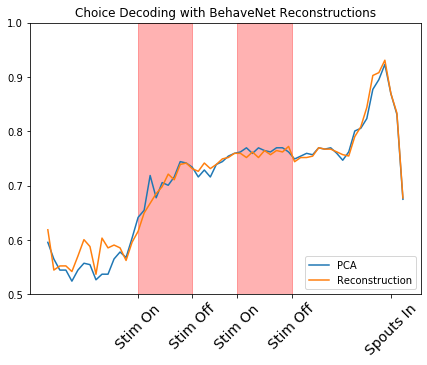

In [81]:
# Plot decoding accuracy over time
start_frame = []
accuracy = []
accuracy_og = []
plt.figure(figsize=(7,5))
for frame, log_reg in enumerate(results):
    if log_reg == None:
        continue
    start_frame.append(frame*2)
    accuracy.append(
        np.max(np.mean(log_reg.scores_[1], axis=0))
        )
    
    log_reg_og = results_og[frame]
    accuracy_og.append(
        np.max(np.mean(log_reg_og.scores_[1], axis=0))
        )
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.axvspan(30, 30+18, alpha=0.3, color='red')
plt.axvspan(30+33, 30+51, alpha=0.3, color='red')
plt.title("Choice Decoding with BehaveNet Reconstructions")
plt.ylim((0.5,1))
sns.lineplot(x=start_frame, y=accuracy, label="PCA")
sns.lineplot(x=start_frame, y=accuracy_og, label="Reconstruction")

## 3. Set the parameters of the ARHMM

In [7]:
T = num_bins # Number of time bins
K = 0 # Number of discrete states; a hyperparameter
N = 0 # Number of observed dimensions; set in the function
num_iters = 100
kappa = 10

In [15]:
def fit_arhmm(K, data):
    """
    Fits and returns an ARHMM on the given data
    
    Args
        K: Number of discrete states
        Data: a (trials x bins x regions) array
    Returns
        
    """
    
    N = data.shape[2]
    data = [data[i,:,:] for i in np.arange(data.shape[0])]
    
    # shuffle the trials
    shuff_sequence = [i for i in range(len(data))]
    npr.shuffle(shuff_sequence)
    shuff_sequence = np.array(shuff_sequence)
    
    # Divide into training and testing
    divider_idx = int(np.ceil(0.8*len(data)))
    train_indices = shuff_sequence[:divider_idx]
    test_indices = shuff_sequence[divider_idx:]
    data_train = [data[i] for i in train_indices]
    data_test = [data[i] for i in test_indices]
    
    # Run the ARHMM
    arhmm = HMM(
        K, N, observations="ar",
        transitions="sticky",
        transition_kwargs=dict(kappa=kappa)
        )
    lls = arhmm.fit(
        data_train, method = "em",
        num_em_iters = num_iters
        )
    
    return arhmm, lls, train_indices, test_indices

In [8]:
K_range = np.arange(2,16,1)

In [20]:
# Collect results
results = {}
results['arhmm'] = []
results['lls'] = []
results['train_indices'] = []
results['test_indices'] = []
for K in K_range:
    arhmm, lls, train_indices, test_indices = fit_arhmm(K, pc_data)
    results['arhmm'].append(arhmm)
    results['lls'].append(lls)
    results['train_indices'].append(train_indices)
    results['test_indices'].append(test_indices)

In [21]:
with open("arhmm_reconstructions.p", "wb") as f:
    pickle.dump(results, f)

## 4. Choose the best $K$ by checking the log-likelihood

In [9]:
with open("arhmm_reconstructions.p", "rb") as f:
    results = pickle.load(f)

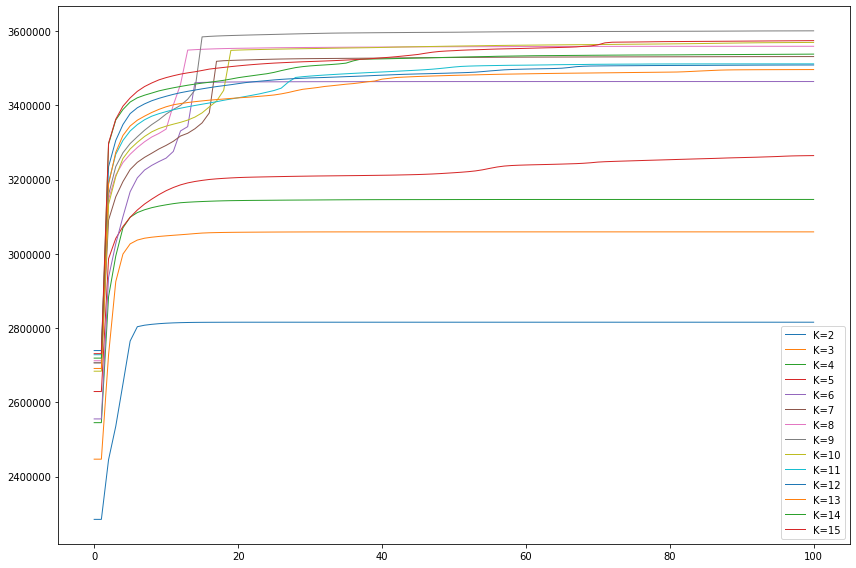

In [23]:
# Plot log likelihoods if you want to see convergence
plt.figure(figsize=(12, 8))
all_lls = []
for idx, K in enumerate(K_range):
    lls = results['lls'][idx]
    line = None
    color = line.get_color() if line is not None else None
    line = plt.plot(lls, lw=1, color=color, label="K=%d"%K)[0]

xlim = plt.xlim()
plt.xlim(xlim)
plt.legend(loc="lower right")
plt.tight_layout()

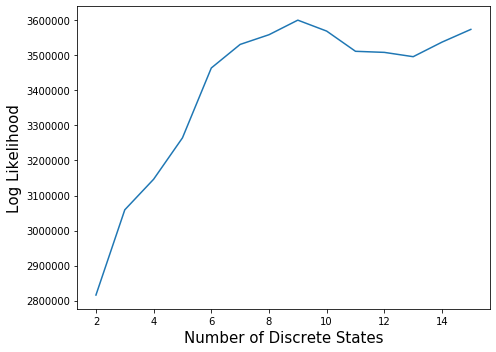

In [85]:
# Compare log likelihoods as K increases
plt.figure(figsize=(7,5))
all_lls = []
for idx, K in enumerate(K_range):
    lls = results['lls'][idx]
    all_lls.append(np.max(lls))
plt.plot(K_range, all_lls)
plt.xlabel("Number of Discrete States", fontsize=15)
plt.ylabel("Log Likelihood", fontsize=15)
plt.tight_layout()

In [13]:
best_K = 6

## 5. Check how well the "smoothed" version looks

In [14]:
best_arhmm = results['arhmm'][best_K - 2]
test_indices = results['test_indices'][best_K - 2]
train_indices = results['train_indices'][best_K - 2]

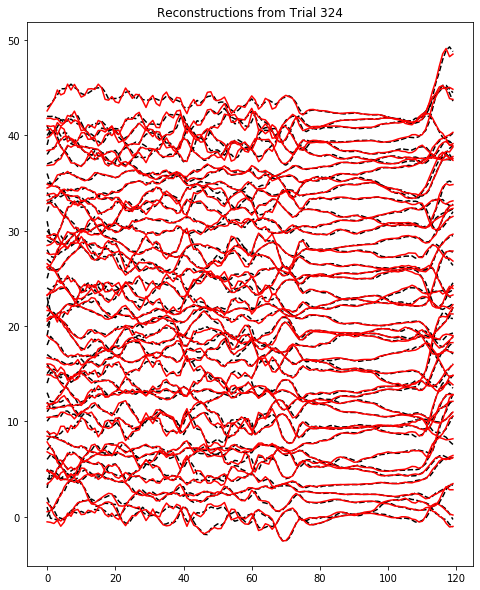

In [15]:
# Look at sample reconstructions
plt.figure(figsize=(8,10))
trial = test_indices[npr.randint(test_indices.size)]
test = best_arhmm.smooth(pc_data[trial,:,:])
plt.plot(np.arange(44) + test, 'k--', label="Smoothed")
plt.plot(np.arange(44) + pc_data[trial,:,:], label="Real", color = 'r')
plt.title("Reconstructions from Trial %d"%trial)
plt.show()

## 6. Plot the inferred states

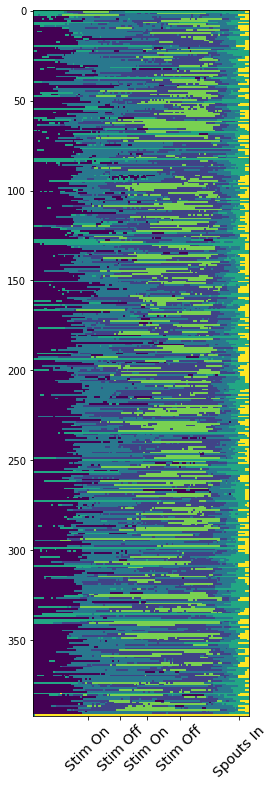

In [16]:
# Plot sequentially over all trials
trial_states = []
for trial in np.arange(pc_data.shape[0]):
    states = best_arhmm.most_likely_states(pc_data[trial,:,:])
    trial_states.append(states)
trial_states = np.array(trial_states)
plt.figure(figsize=(15,13))
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.imshow(trial_states)
plt.show()

## 7. Plot inferred states for L/R choices

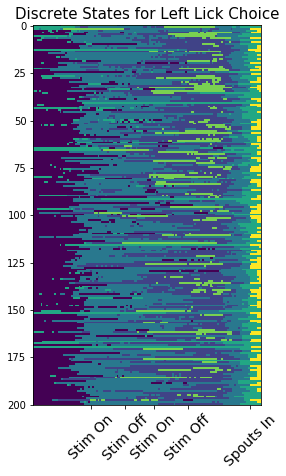

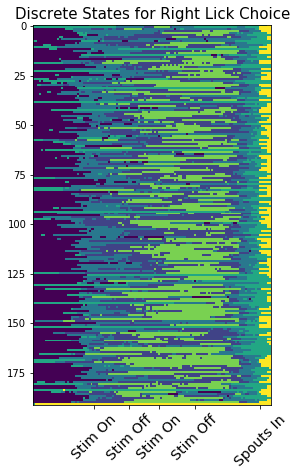

In [17]:
# Plot the states, separating by lick direction
l_states = []
r_states = []
for trial, choice in enumerate(trial_choices):
    states = best_arhmm.most_likely_states(pc_data[trial,:,:])
    if choice == 1:
        l_states.append(states)
    else:
        r_states.append(states)
l_states = np.array(l_states)
r_states = np.array(r_states)

plt.figure(figsize=(10,7))
plt.imshow(l_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Left Lick Choice", fontsize=15)
plt.show()

plt.figure(figsize=(10,7))
plt.imshow(r_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Right Lick Choice", fontsize=15)
plt.show()

## 8. Plot the inferred states for correct/incorrect trials

In [18]:
trial_correctchoice = session.trialmarkers['CorrectSide']

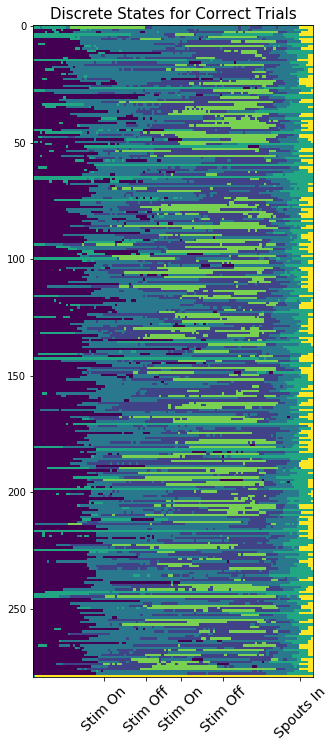

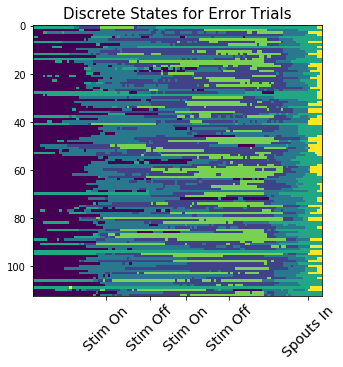

In [19]:
# Plot the states, separating by correctness of choice
correct_states = []
error_states = []
for trial, choice in enumerate(trial_choices):
    correctchoice = trial_correctchoice[trial]
    states = best_arhmm.most_likely_states(pc_data[trial,:,:])
    if choice == correctchoice:
        correct_states.append(states)
    else:
        error_states.append(states)
correct_states = np.array(correct_states)
error_states = np.array(error_states)

plt.figure(figsize=(15,12))
plt.imshow(correct_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Correct Trials", fontsize=15)
plt.show()

plt.figure(figsize=(10,5))
plt.imshow(error_states)
plt.xticks(
    ticks=[30, 30+18, 30+33, 30+51, 30+84],
    labels=['Stim On', 'Stim Off', 'Stim On', 'Stim Off', 'Spouts In'],
    rotation=45, fontsize=14
    )
plt.title("Discrete States for Error Trials", fontsize=15)
plt.show()